#

$x$ je skalarna veličina koja se mjeri $N$ puta da bi se formirao skup podataka.

- $x_i$ je pojedinačno mjerenje za $i = 1, \dots, N$.
- $\{x_i\}$ označava skup svih $N$ mjerenja koja čine skup podataka.

Podaci mogu biti realni brojevi, diskretne oznake (stringovi ili brojevi), ili čak „nedostajuće vrijednosti” (tad 

koristimo $NaN$).

#### Cilj "rudarenja" podataka i statističkog zaključivanja:

$\blacksquare$ Generalno, pokušavamo da **procijenimo** $h(x)$, **stvarnu** distribuciju vjerovatnoće iz koje

su uzeti podaci $\{x_i\}$ slučajno odabrani.

- $h(x)$ predstavlja **funkciju gustine vjerovatnoće** (engl. *Probability Density Function* - PDF),

    pri čemu je $h(x)dx$ definisana kao vjerovatnoća da slučajna promjenljiva $x$ poprimi vrednost u intervalu
    
    $[x, x + dx]$. Ova distribucija može imati različite nivoe - od klasične raspodjele fizičkih parametara

    (npr. distribucije crvenog pomaka kosmičkih izvora) do distribucije neodređenosti mjerenja koja uvodi dodatnu

    stohastičku komponentu u posmatrane vrijednosti.  

- **Integral** $h(x)$ određuje **kumulativnu funkciju distribucije** (engl. *Cumulative Distribution Function* - CDF),

    definisanu kao:  
      $$
      H(x) = \int_{-\infty}^{x} h(x')dx'.
      $$
  
- Inverzna funkcija od $H(x)$ je tzv. **kvantilna funkcija** i omogućava određivanje vrijednosti $x$ ispod koje
  
  se nalazi određeni procenat ukupne raspodjele (npr. 90%).  

- Iako $h(x)$ predstavlja „idealizovanu” distribuciju podataka (poznatu i kao **populaciona** funkcija gustine),

    eksperimentalno dostupni podaci omogućavaju samo aproksimaciju putem **empirijske** funkcije gustine
    
    vjerovatnoće, označene kao $f(x)$. Dakle, $f(x)$ može biti shvaćen kao **model** za $h(x)$. U teorijskom 
    
    limitu beskonačne količine podataka, $f(x) \to h(x)$, ali u realnim uslovima efekti nesigurnosti mjerenja
    
    i ograničene veličine uzorka uzrokuju odstupanja. Slično tome, empirijska kumulativna distribucija označava
    
    se sa $F(x)$.  

- U situacijama kada nastojimo da konstruisemo **fizički model** funkcije $h(x)$, govorimo o **parametarskoj** 

    metodologiji. U tom slučaju, odabir matematičke forme modela omogućava generisanje novih sintetičkih
    
    podataka koji bi trebalo da reprodukuju osnovne karakteristike posmatranih veličina. Nasuprot tome, ukoliko
    
    ne  postavljamo eksplicitne pretpostavke o formi funkcije $h(x)$, već je empirijski aproksimiramo iz
    
    podataka, proces se kvalifikuje kao **neparametarski** – cilj je deskriptivna karakterizacija podataka 
    
    bez eksplicitnog
    
    modelovanja fenomena koji ih generiše.  

#### Vizualizacija (tj. fundamentalno razumijevanje) PDF-a predstavlja nelinearan problem!  

Razmatrajmo ilustrativni primer. U okviru ovog eksperimenta, prvo ćemo definisati početnu distribuciju $h(x)$, 

zatim generisati uzorak slučajnih podataka $\{x_i\}$, a potom pokušati da aproksimiramo empirijsku raspodjelu 

koristeći i parametarske i neparametarske metode procene funkcije gustine verovatnoće $f(x)$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

In [3]:
random_state = np.random.RandomState(seed=0)
N = 2000 # number of data points
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

In [5]:
print(x.tolist()[:10])

[8.952596638950636, 6.942533358935216, 11.857502968790328, 7.9673676256550765, 8.339793768997136, 9.104030518710326, 9.034882898224481, 9.00066149734176, 12.068202801788292, 12.43803660691054]


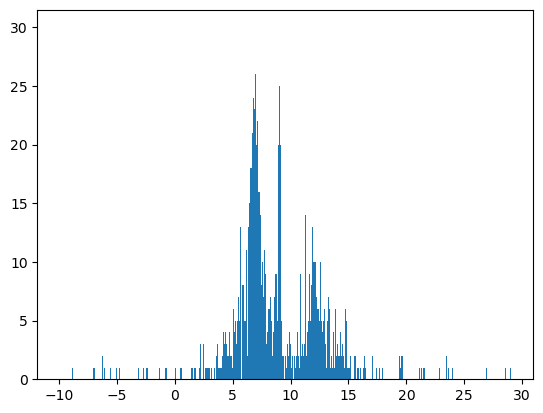

In [6]:
plt.hist(x,bins=1000);

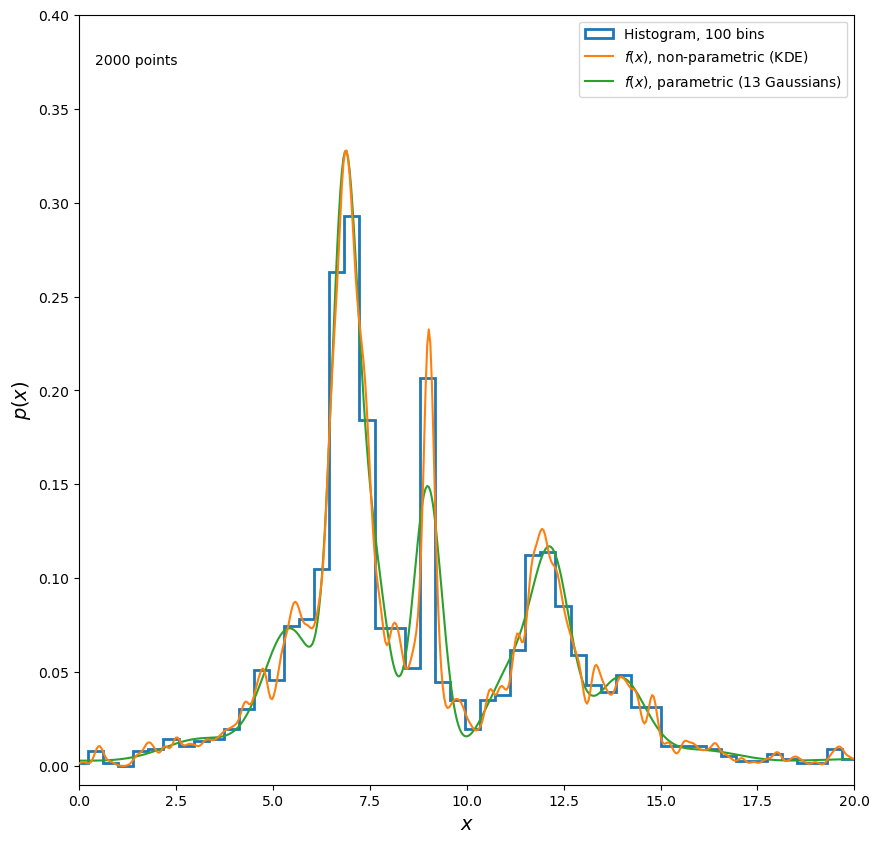

In [7]:
#------------------------------------------------------------
# plot the results
fig,ax = plt.subplots(figsize=(10, 10))
xgrid = np.linspace(-10, 30, 1000)

# True distribution: you typically don't have it! Only have the samples!
if False:
    ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")

# A simple histogram
# But try changing the number of bins!
if True:
    ax.hist(x,density=True,color='C0',bins=100,histtype='step',lw=2, label='Histogram, 100 bins')

# Something more sophisticated: Kernel Density Estimation
# But try changing the bandwith! 
if True:
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(x[:, None])
    dens_kde = np.exp(kde.score_samples(xgrid[:, None]))
    ax.plot(xgrid, dens_kde, '-', color='C1', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# Use Gaussian Mixtures with a pre-defined number of clusters (13)
if True:
    gmm = GaussianMixture(n_components=13).fit(x.reshape(-1, 1))
    logprob = gmm.score_samples(xgrid.reshape(-1, 1))
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))
    ax.plot(xgrid, fx(np.array(xgrid)), '-', color='C2',
            label="$f(x)$, parametric (13 Gaussians)")

# Plot cosmetics
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()

In [8]:
# For instance in a single point:
print(hx(9))             # h(x), the true distribution

print(fx(np.array([9]))) # f(x) for a parametric model
print(np.exp(kde.score_samples(np.atleast_2d(9)))) # f(x) for non-parametric model

0.34357186498273545
[0.14908797]
[0.23034853]
